# CNN from Scratch

## Environment Setup

In [ ]:
import pandas as pd
import tensorflow as tf
import os
import shutil
import numpy as np
from tensorflow import keras
from tensorflow.keras import optimizers
from keras import layers
from keras import models
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from numpy import expand_dims
from matplotlib import pyplot
from keras.models import Model
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
import seaborn as sns
from tensorflow.keras import regularizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CLASSES = ['Paul_Gauguin',
 'Edgar_Degas',
 'Vincent_van_Gogh',
 'Albrecht_Dürer',
 'Pablo_Picasso',
 'Titian',
 'Francisco_Goya',
 'Marc_Chagall',
 'Pierre-Auguste_Renoir',
 'Alfred_Sisley',
 'Rembrandt']

TRAIN_DIR = '/content/drive/Shareddrives/DeepLearning-ArtClassification/Data/Split-dataset/train'
TEST_DIR = '/content/drive/Shareddrives/DeepLearning-ArtClassification/Data/Split-dataset/test'
VAL_DIR = '/content/drive/Shareddrives/DeepLearning-ArtClassification/Data/Split-dataset/val'

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 32
RANDOM_SEED = 47

MODEL_DIR = "/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/CNN_from_scratch"

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

LOCAL_PATH = "/content/model"

if not os.path.exists(LOCAL_PATH):
    os.makedirs(LOCAL_PATH)

DROPOUT_PERC = 0.5

CNN Class Base Model

In [ ]:
class CNN:

  def __init__(self, train, test, val, name="baseCNN"):
      
      # import dataset into the class
      self.train = train
      self.test = test 
      self.val = val
      
      self.name = name
      self.history = None
      self.pred_labels = None

      # model structure
      inputs = keras.Input(shape=(224, 224, 3))
      x = layers.Rescaling(1./255)(inputs)
      x = layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), padding="same", activation="relu")(x)
      x = layers.MaxPooling2D(pool_size=(2,2))(x)
      x = layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), padding="same", activation="relu")(x)
      x = layers.MaxPooling2D(pool_size=(3,3))(x)
      x = layers.Flatten()(x)
      outputs = layers.Dense(len(CLASSES), activation="softmax")(x)
      self.model = keras.Model(inputs=inputs, outputs=outputs, name=self.name)


  def summary(self):
    return self.model.summary()


  def compile(self, learning_rate = 0.0001, loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = "accuracy"):

    # chose optimizer
    if optimizer == "adam":
      custom_opt = optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "adam_adaptive":
      custom_opt = tf.keras.optimizers.AdamW(learning_rate=learning_rate)
    
    self.model.compile(loss = loss, optimizer = custom_opt, metrics = [metrics])



  def fit(self, epochs = 20, patience = None, class_weights = None):

    model_path = LOCAL_PATH + "/" + self.name + ".h5"

    if patience == None:
      callbacks = [
          keras.callbacks.ModelCheckpoint(filepath = model_path, monitor="val_loss", verbose=1, save_best_only=True)
      ]
    else:
      callbacks = [
          tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience),
          keras.callbacks.ModelCheckpoint(filepath = model_path, monitor="val_loss", verbose=1, save_best_only=True)
      ]

    self.history = self.model.fit(self.train, validation_data = self.val, epochs=epochs, callbacks = callbacks, class_weight=class_weights)

    shutil.copy(model_path, MODEL_DIR + "/" + self.name + ".h5")

    # We load the best model before the evaluation occurs
    self.model = models.load_model(MODEL_DIR + "/" + self.name + ".h5")

  def evaluate(self):
    self.model.evaluate(self.test)

    true_labels = np.concatenate([y for x, y in self.test], axis=0)
    pred_labels = self.model.predict(self.test)
    pred_labels = np.argmax(pred_labels, axis=-1)
    self.pred_labels = pred_labels
    print(classification_report(true_labels, self.pred_labels, target_names = CLASSES))

  def plot_results(self):
    plt.plot(self.history.history['accuracy'])
    plt.plot(self.history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    index_best_loss = np.argmin(self.history.history["val_loss"])
    best_loss = np.min(self.history.history["val_loss"])
    
    plt.plot(self.history.history['loss'])
    plt.plot(self.history.history['val_loss'])
    plt.plot(index_best_loss, best_loss, "ro")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val', 'chosen model'], loc='upper left')
    plt.show()


  def confusion_matrix(self):

    true_labels = np.concatenate([y for x, y in self.test], axis=0)
    fig, ax = plt.subplots(figsize=(10, 10))
    ConfusionMatrixDisplay.from_predictions(true_labels, self.pred_labels, xticks_rotation='vertical', ax=ax, display_labels=CLASSES)

  
  def plot_model_structure(self, name):
    tf.keras.utils.plot_model(self.model, to_file=name+'.png', show_shapes=True, show_layer_names=True)


### Dataset Loading

In [ ]:
training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=False,
    seed=RANDOM_SEED
)


val_images = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)


Found 3004 files belonging to 11 classes.
Found 656 files belonging to 11 classes.
Found 639 files belonging to 11 classes.


## Class Weights

In [ ]:
import os
import csv

main_folder = '/content/drive/Shareddrives/DeepLearning-ArtClassification/Data/Split-dataset/train'

path_new_csv = '/content/drive/Shareddrives/DeepLearning-ArtClassification/Data/artist_class_weigth.csv'

with open(path_new_csv, mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['Artist', 'Paintings'])
    
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)
        if os.path.isdir(subfolder_path):
            image_count = len([f for f in os.listdir(subfolder_path)])
            writer.writerow([subfolder, image_count])



In [ ]:
artists = pd.read_csv(path_new_csv)
artists['class_weight'] = artists.Paintings.sum()/(len(CLASSES) * artists.Paintings)

CLASS_WEIGHTS = artists['class_weight'].to_dict()
CLASS_WEIGHTS

{0: 1.258483452031839,
 1: 0.556193297537493,
 2: 0.44549903603737206,
 3: 1.1925367209210005,
 4: 0.889546935149541,
 5: 1.5342185903983656,
 6: 1.3452754142409316,
 7: 1.6352749047359825,
 8: 1.1620889748549323,
 9: 1.508789552988448,
 10: 1.4923000496770988}

# CNN with class


## CNN Base Model - Conv Layer = 2

In [ ]:
baseCNN = CNN(training_images, test_images, val_images)

In [ ]:
baseCNN.summary()

Model: "baseCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                       

In [ ]:
baseCNN.compile()

In [ ]:
baseCNN.fit(epochs=20, class_weights = CLASS_WEIGHTS)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 2.5672 - accuracy: 0.2007 
Epoch 1: val_loss improved from inf to 2.24854, saving model to /content/model/baseCNN.h5
94/94 [==============================] - 1327s 13s/step - loss: 2.5672 - accuracy: 0.2007 - val_loss: 2.2485 - val_accuracy: 0.2050
Epoch 2/20
92/94 [============================>.] - ETA: 0s - loss: 2.3453 - accuracy: 0.2361
Epoch 2: val_loss improved from 2.24854 to 2.01986, saving model to /content/model/baseCNN.h5
94/94 [==============================] - 6s 64ms/step - loss: 2.3435 - accuracy: 0.2350 - val_loss: 2.0199 - val_accuracy: 0.2629
Epoch 3/20
92/94 [============================>.] - ETA: 0s - loss: 2.1384 - accuracy: 0.2972
Epoch 3: val_loss improved from 2.01986 to 1.90084, saving model to /content/model/baseCNN.h5
94/94 [==============================] - 6s 64ms/step - loss: 2.1367 - accuracy: 0.2973 - val_loss: 1.9008 - val_accuracy: 0.3067
Epoch 4/20
92/94 [============================>

In [ ]:
baseCNN.evaluate()

21/21 [==============================] - 1s 47ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.84      0.82      0.83        50
          Edgar_Degas       0.78      0.45      0.57        40
     Vincent_van_Gogh       0.83      0.41      0.54       106
       Albrecht_Dürer       0.65      0.53      0.59        45
        Pablo_Picasso       0.62      0.43      0.51        37
               Titian       0.56      0.34      0.43        67
       Francisco_Goya       0.54      0.56      0.55        48
         Marc_Chagall       0.34      0.61      0.44        51
Pierre-Auguste_Renoir       0.66      0.62      0.64        40
        Alfred_Sisley       0.45      0.77      0.57        39
            Rembrandt       0.52      0.71      0.60       133

             accuracy                           0.57       656
            macro avg       0.62      0.57      0.57       656
         weighted avg       0.62      0.57      0.57       656

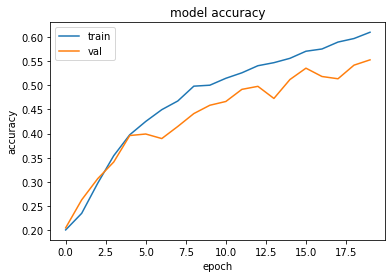

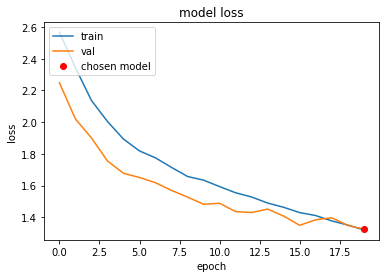

In [ ]:
baseCNN.plot_results()

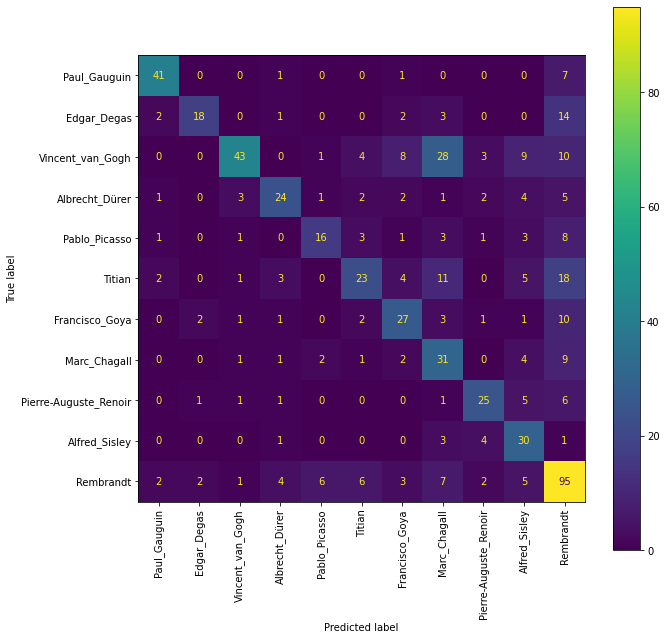

In [ ]:
baseCNN.confusion_matrix()

In [ ]:
baseCNN.plot_model_structure("BaseCNN")

## Conv Layer = 2 Learning Rate = 0.001

In [ ]:
baseCNN_LR = CNN(training_images, test_images, val_images, name = "higher_LR")

In [ ]:
baseCNN_LR.summary()

Model: "higher_LR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                     

In [ ]:
baseCNN_LR.compile(learning_rate=0.001)

In [ ]:
baseCNN_LR.fit(epochs=20, class_weights = CLASS_WEIGHTS)

Epoch 1/20
93/94 [============================>.] - ETA: 0s - loss: 2.2661 - accuracy: 0.2675
Epoch 1: val_loss improved from inf to 1.72212, saving model to /content/model/higher_LR.h5
94/94 [==============================] - 7s 66ms/step - loss: 2.2651 - accuracy: 0.2680 - val_loss: 1.7221 - val_accuracy: 0.3818
Epoch 2/20
93/94 [============================>.] - ETA: 0s - loss: 1.8081 - accuracy: 0.4224
Epoch 2: val_loss improved from 1.72212 to 1.48346, saving model to /content/model/higher_LR.h5
94/94 [==============================] - 6s 64ms/step - loss: 1.8060 - accuracy: 0.4234 - val_loss: 1.4835 - val_accuracy: 0.4789
Epoch 3/20
92/94 [============================>.] - ETA: 0s - loss: 1.6086 - accuracy: 0.5071
Epoch 3: val_loss improved from 1.48346 to 1.36359, saving model to /content/model/higher_LR.h5
94/94 [==============================] - 6s 64ms/step - loss: 1.6052 - accuracy: 0.5093 - val_loss: 1.3636 - val_accuracy: 0.4977
Epoch 4/20
92/94 [==========================

In [ ]:
baseCNN_LR.evaluate()

21/21 [==============================] - 1s 50ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.84      0.82      0.83        50
          Edgar_Degas       0.77      0.50      0.61        40
     Vincent_van_Gogh       0.69      0.70      0.69       106
       Albrecht_Dürer       0.55      0.53      0.54        45
        Pablo_Picasso       0.55      0.43      0.48        37
               Titian       0.73      0.28      0.41        67
       Francisco_Goya       0.65      0.42      0.51        48
         Marc_Chagall       0.37      0.63      0.47        51
Pierre-Auguste_Renoir       0.73      0.55      0.63        40
        Alfred_Sisley       0.60      0.72      0.65        39
            Rembrandt       0.56      0.76      0.64       133

             accuracy                           0.61       656
            macro avg       0.64      0.58      0.59       656
         weighted avg       0.64      0.61      0.60       656

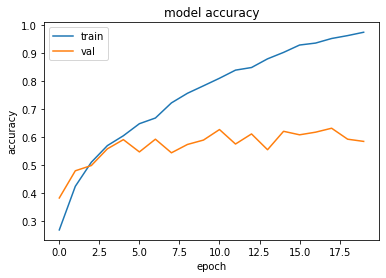

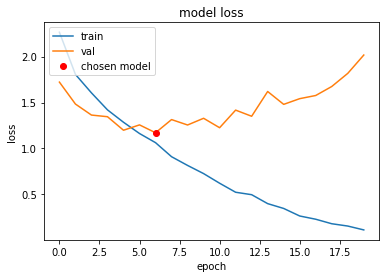

In [ ]:
baseCNN_LR.plot_results()

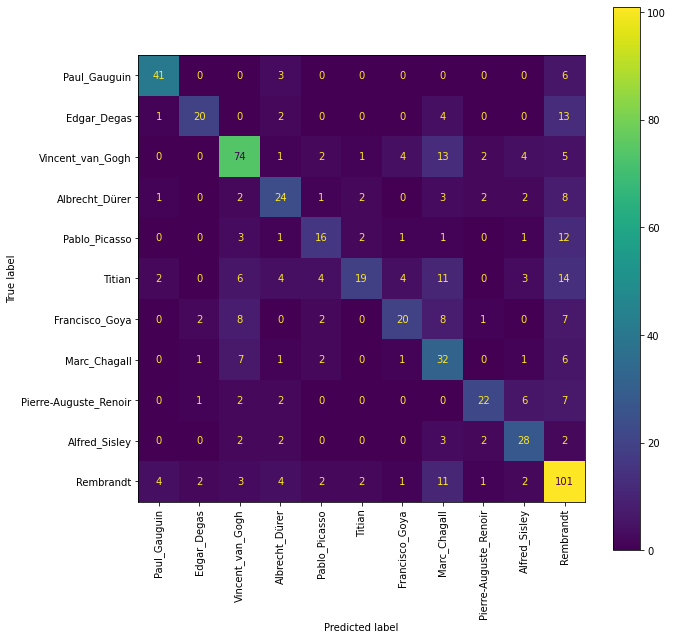

In [ ]:
baseCNN_LR.confusion_matrix()

## CNN: ConvLayer=3, Early Stopping, Dropout

In [ ]:
class CNN_3(CNN): 
  def __init__(self, train, test, val, name="CNN_Conv3_Drop"):
      super().__init__(train, test, val, name)

      # model structure
      inputs = keras.Input(shape=(224, 224, 3))
      x = layers.Rescaling(1./255)(inputs)
      x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x)
      x = layers.MaxPooling2D(pool_size=(2,2))(x)
      x = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
      x = layers.MaxPooling2D(pool_size=(3,3))(x)
      #Extended part
      x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
      x = layers.MaxPooling2D(pool_size=(3,3))(x)
      x = layers.Flatten()(x)
      x = layers.Dropout(0.3)(x) 
      outputs = layers.Dense(len(CLASSES), activation="softmax")(x)
      self.model = keras.Model(inputs=inputs, outputs=outputs, name=self.name)

In [ ]:
CNN_Conv3_Drop = CNN_3(training_images, test_images, val_images)

In [ ]:
CNN_Conv3_Drop.summary()

Model: "CNN_Conv3_Drop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_37 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_104 (Conv2D)         (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_103 (MaxPooli  (None, 112, 112, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_105 (Conv2D)         (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_104 (MaxPooli  (None, 37, 37, 64)       0         
 ng2D)                                              

In [ ]:
CNN_Conv3_Drop.compile(learning_rate = 0.001)

In [ ]:
CNN_Conv3_Drop.fit(epochs=20, patience = 5, class_weights = CLASS_WEIGHTS)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 2.1662 - accuracy: 0.3049
Epoch 1: val_loss improved from inf to 1.60996, saving model to /content/model/CNN_Conv3_Drop.h5
94/94 [==============================] - 8s 77ms/step - loss: 2.1662 - accuracy: 0.3049 - val_loss: 1.6100 - val_accuracy: 0.4241
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 1.7096 - accuracy: 0.4740
Epoch 2: val_loss improved from 1.60996 to 1.39340, saving model to /content/model/CNN_Conv3_Drop.h5
94/94 [==============================] - 7s 76ms/step - loss: 1.7096 - accuracy: 0.4740 - val_loss: 1.3934 - val_accuracy: 0.5164
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 1.4045 - accuracy: 0.5676
Epoch 3: val_loss improved from 1.39340 to 1.30957, saving model to /content/model/CNN_Conv3_Drop.h5
94/94 [==============================] - 8s 76ms/step - loss: 1.4045 - accuracy: 0.5676 - val_loss: 1.3096 - val_accuracy: 0.5571
Epoch 4/20
93/94 [===========

In [ ]:
CNN_Conv3_Drop.evaluate()

21/21 [==============================] - 1s 55ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.85      0.88      0.86        50
          Edgar_Degas       0.60      0.65      0.63        40
     Vincent_van_Gogh       0.72      0.67      0.70       106
       Albrecht_Dürer       0.51      0.60      0.55        45
        Pablo_Picasso       0.58      0.59      0.59        37
               Titian       0.67      0.58      0.62        67
       Francisco_Goya       0.58      0.54      0.56        48
         Marc_Chagall       0.42      0.53      0.47        51
Pierre-Auguste_Renoir       0.74      0.50      0.60        40
        Alfred_Sisley       0.59      0.62      0.60        39
            Rembrandt       0.68      0.69      0.68       133

             accuracy                           0.64       656
            macro avg       0.63      0.62      0.62       656
         weighted avg       0.65      0.64      0.64       656

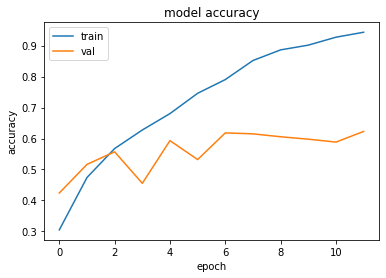

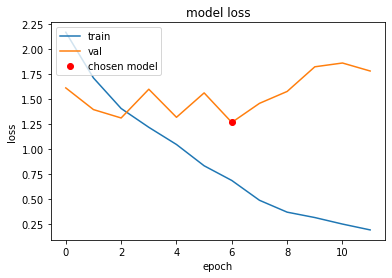

In [ ]:
CNN_Conv3_Drop.plot_results()

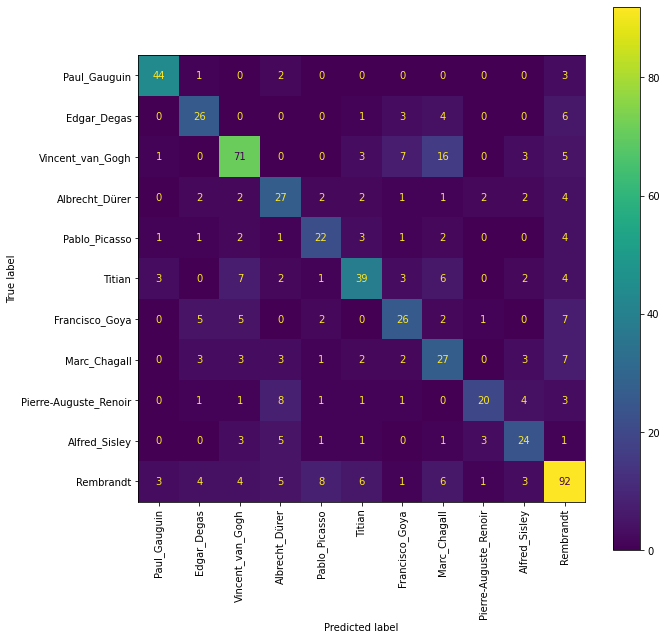

In [ ]:
CNN_Conv3_Drop.confusion_matrix()

In [ ]:
CNN_Conv3_Drop.plot_model_structure("Conv3Drop")

## CNN: ConvLayer=3, Dropout, Strides

In [ ]:
class CNN_4(CNN): 
  def __init__(self, train, test, val, name="CNN_Conv3_Dense_Strides"):
      super().__init__(train, test, val, name)

      # model structure
      inputs = keras.Input(shape=(224, 224, 3))
      x = layers.Rescaling(1. / 255)(inputs)
      x = layers.Conv2D(filters=32, kernel_size=3, strides=(7,7), padding="same", activation="relu")(x)
      x = layers.MaxPooling2D(pool_size=(4,4), strides=4)(x)
      x = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
      x = layers.MaxPooling2D(pool_size=(2,2))(x)
      x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
      x = layers.MaxPooling2D(pool_size=(2,2))(x)
      x = layers.Flatten()(x)
      x = layers.Dense(128)(x)
      x = layers.Dropout(0.28)(x)
      outputs = layers.Dense(len(CLASSES), activation="softmax")(x)
      self.model = keras.Model(inputs=inputs, outputs=outputs, name=self.name)

In [ ]:
CNN_Conv3_Dense_Strides = CNN_4(training_images, test_images, val_images)

In [ ]:
CNN_Conv3_Dense_Strides.summary()

Model: "CNN_Conv3_Dense_Strides"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                       

In [ ]:
CNN_Conv3_Dense_Strides.compile(learning_rate=0.001)

In [ ]:
CNN_Conv3_Dense_Strides.fit(epochs=40, patience=5, class_weights = CLASS_WEIGHTS)

Epoch 1/40
94/94 [==============================] - ETA: 0s - loss: 2.4300 - accuracy: 0.2320
Epoch 1: val_loss improved from inf to 1.93764, saving model to /content/model/CNN_test.h5
94/94 [==============================] - 8s 74ms/step - loss: 2.4300 - accuracy: 0.2320 - val_loss: 1.9376 - val_accuracy: 0.3083
Epoch 2/40
93/94 [============================>.] - ETA: 0s - loss: 2.0419 - accuracy: 0.3199
Epoch 2: val_loss improved from 1.93764 to 1.67257, saving model to /content/model/CNN_test.h5
94/94 [==============================] - 7s 72ms/step - loss: 2.0410 - accuracy: 0.3189 - val_loss: 1.6726 - val_accuracy: 0.3662
Epoch 3/40
90/94 [===========================>..] - ETA: 0s - loss: 1.8621 - accuracy: 0.3927
Epoch 3: val_loss improved from 1.67257 to 1.54322, saving model to /content/model/CNN_test.h5
94/94 [==============================] - 6s 63ms/step - loss: 1.8595 - accuracy: 0.3891 - val_loss: 1.5432 - val_accuracy: 0.4257
Epoch 4/40
94/94 [=============================

In [ ]:
CNN_Conv3_Dense_Strides.evaluate()

21/21 [==============================] - 1s 52ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.82      0.82      0.82        50
          Edgar_Degas       0.96      0.55      0.70        40
     Vincent_van_Gogh       0.67      0.60      0.63       106
       Albrecht_Dürer       0.55      0.53      0.54        45
        Pablo_Picasso       0.69      0.73      0.71        37
               Titian       0.55      0.60      0.57        67
       Francisco_Goya       0.66      0.60      0.63        48
         Marc_Chagall       0.49      0.65      0.55        51
Pierre-Auguste_Renoir       0.64      0.57      0.61        40
        Alfred_Sisley       0.57      0.51      0.54        39
            Rembrandt       0.64      0.71      0.68       133

             accuracy                           0.64       656
            macro avg       0.66      0.63      0.63       656
         weighted avg       0.65      0.64      0.64       656

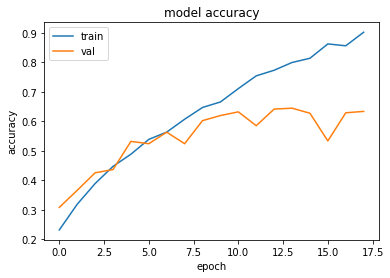

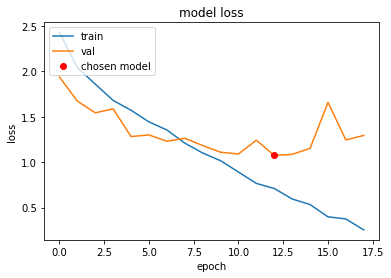

In [ ]:
CNN_Conv3_Dense_Strides.plot_results()

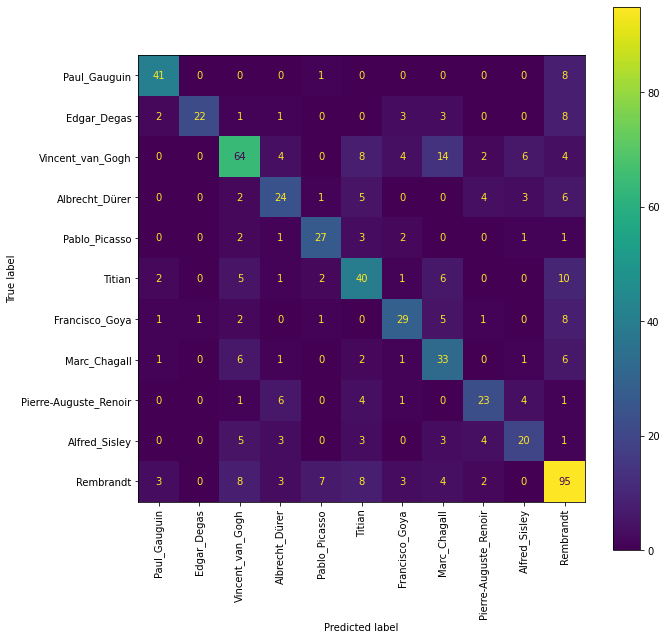

In [ ]:
CNN_Conv3_Dense_Strides.confusion_matrix()

In [ ]:
CNN_Conv3_Dense_Strides.plot_model_structure("CNN_Conv3_Dense_Strides")

## CNN: ConvLayer=3, Dropout, Strides, L2 Regularization

In [ ]:
class CNN_5(CNN): 
  def __init__(self, train, test, val, name="CNN_Conv3_Dense_Strides_Reg"):
      super().__init__(train, test, val, name)

      # model structure
      inputs = keras.Input(shape=(224, 224, 3))
      x = layers.Rescaling(1. / 255)(inputs)
      x = layers.Conv2D(filters=32, kernel_size=3, strides=(7,7), padding="same", activation="relu", kernel_regularizer=regularizers.L2(l2=0.04))(x)
      x = layers.MaxPooling2D(pool_size=(4,4), strides=4)(x)
      x = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_regularizer=regularizers.L2(l2=0.04))(x)
      x = layers.MaxPooling2D(pool_size=(2,2))(x)
      x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", kernel_regularizer=regularizers.L2(l2=0.04))(x)
      x = layers.MaxPooling2D(pool_size=(2,2))(x)
      x = layers.Flatten()(x)
      x = layers.Dense(220)(x)
      #x = layers.Dropout(0.3)(x)
      outputs = layers.Dense(len(CLASSES), activation="softmax")(x)
      self.model = keras.Model(inputs=inputs, outputs=outputs, name=self.name)

In [ ]:
CNN_Conv3_Dense_Strides_Reg = CNN_5(training_images, test_images, val_images)

In [ ]:
CNN_Conv3_Dense_Strides_Reg.summary()

Model: "CNN_Conv3_Dense_Strides_Reg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                   

In [ ]:
CNN_Conv3_Dense_Strides_Reg.compile(learning_rate=0.001)

In [ ]:
CNN_Conv3_Dense_Strides_Reg.fit(epochs=200, patience=25, class_weights = CLASS_WEIGHTS)

Epoch 1/200
94/94 [==============================] - ETA: 0s - loss: 3.9410 - accuracy: 0.2167 
Epoch 1: val_loss improved from inf to 2.33713, saving model to /content/model/CNN_Conv3_Dense_Strides_Reg.h5
94/94 [==============================] - 1386s 14s/step - loss: 3.9410 - accuracy: 0.2167 - val_loss: 2.3371 - val_accuracy: 0.2864
Epoch 2/200
94/94 [==============================] - ETA: 0s - loss: 2.4703 - accuracy: 0.2793
Epoch 2: val_loss improved from 2.33713 to 2.19162, saving model to /content/model/CNN_Conv3_Dense_Strides_Reg.h5
94/94 [==============================] - 6s 62ms/step - loss: 2.4703 - accuracy: 0.2793 - val_loss: 2.1916 - val_accuracy: 0.2801
Epoch 3/200
91/94 [============================>.] - ETA: 0s - loss: 2.2950 - accuracy: 0.2957
Epoch 3: val_loss improved from 2.19162 to 2.11363, saving model to /content/model/CNN_Conv3_Dense_Strides_Reg.h5
94/94 [==============================] - 6s 61ms/step - loss: 2.2960 - accuracy: 0.2973 - val_loss: 2.1136 - val_a

In [ ]:
CNN_Conv3_Dense_Strides_Reg.evaluate()

21/21 [==============================] - 1s 55ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.79      0.88      0.83        50
          Edgar_Degas       1.00      0.30      0.46        40
     Vincent_van_Gogh       0.53      0.52      0.52       106
       Albrecht_Dürer       0.71      0.56      0.63        45
        Pablo_Picasso       0.54      0.57      0.55        37
               Titian       0.53      0.24      0.33        67
       Francisco_Goya       0.48      0.65      0.55        48
         Marc_Chagall       0.35      0.69      0.46        51
Pierre-Auguste_Renoir       0.59      0.75      0.66        40
        Alfred_Sisley       0.47      0.51      0.49        39
            Rembrandt       0.65      0.59      0.62       133

             accuracy                           0.56       656
            macro avg       0.60      0.57      0.55       656
         weighted avg       0.60      0.56      0.56       656

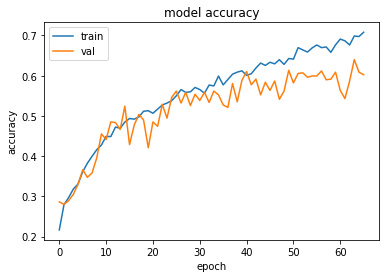

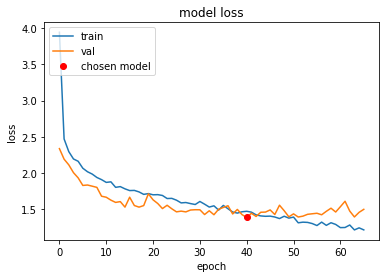

In [ ]:
CNN_Conv3_Dense_Strides_Reg.plot_results()

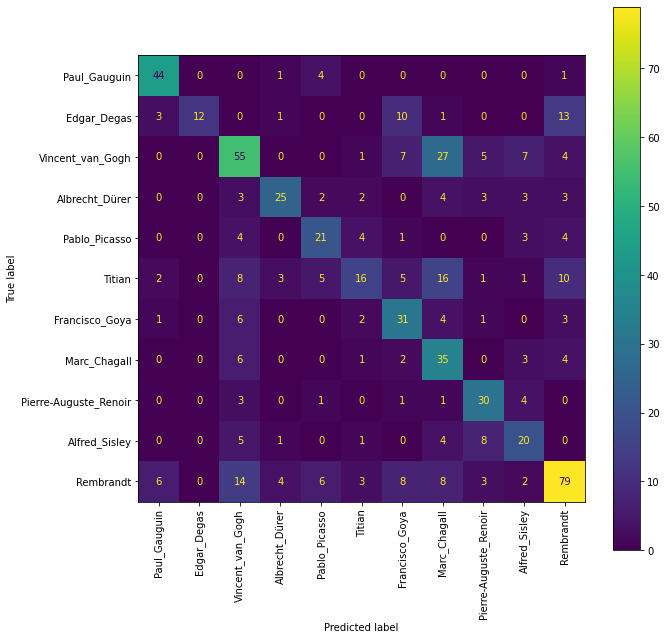

In [ ]:
CNN_Conv3_Dense_Strides_Reg.confusion_matrix()

In [ ]:
CNN_Conv3_Dense_Strides_Reg.plot_model_structure("CNN_Conv3_Dense_Strides_Reg")

## CNN: ConvLayer=3, Dropout, Strides, Deeper Dense

In [ ]:
class CNN_6(CNN): 
  def __init__(self, train, test, val, name="CNN_Deeper_Dense"):
      super().__init__(train, test, val, name)

      inputs = keras.Input(shape=(224, 224, 3))
      x = layers.Rescaling(1. / 255)(inputs)
      x = layers.Conv2D(filters=32, kernel_size=3, strides=(7,7), padding="same")(x)
      x = layers.MaxPooling2D(pool_size=(4,4), strides=4)(x)
      x = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
      x = layers.MaxPooling2D(pool_size=(2,2))(x)
      x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
      x = layers.MaxPooling2D(pool_size=(2,2))(x)
      x = layers.Flatten()(x)
      x = layers.Dense(190)(x)
      x = layers.Dropout(0.5)(x)
      outputs = layers.Dense(len(CLASSES), activation="softmax")(x)
      self.model = keras.Model(inputs=inputs, outputs=outputs, name=self.name)

In [ ]:
CNN_Deeper_Dense = CNN_6(training_images, test_images, val_images)

In [ ]:
CNN_Deeper_Dense.summary()

Model: "CNN_Deeper_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                             

In [ ]:
CNN_Deeper_Dense.compile(learning_rate=0.0009)

In [ ]:
CNN_Deeper_Dense.fit(epochs=40, patience=5, class_weights = CLASS_WEIGHTS)

Epoch 1/40
94/94 [==============================] - ETA: 0s - loss: 2.3909 - accuracy: 0.2330
Epoch 1: val_loss improved from inf to 1.94073, saving model to /content/model/CNN_test_reg.h5
94/94 [==============================] - 11s 89ms/step - loss: 2.3909 - accuracy: 0.2330 - val_loss: 1.9407 - val_accuracy: 0.3005
Epoch 2/40
91/94 [============================>.] - ETA: 0s - loss: 1.9790 - accuracy: 0.3544
Epoch 2: val_loss improved from 1.94073 to 1.66527, saving model to /content/model/CNN_test_reg.h5
94/94 [==============================] - 9s 89ms/step - loss: 1.9842 - accuracy: 0.3532 - val_loss: 1.6653 - val_accuracy: 0.3944
Epoch 3/40
92/94 [============================>.] - ETA: 0s - loss: 1.8056 - accuracy: 0.4018
Epoch 3: val_loss improved from 1.66527 to 1.61645, saving model to /content/model/CNN_test_reg.h5
94/94 [==============================] - 8s 81ms/step - loss: 1.8074 - accuracy: 0.4018 - val_loss: 1.6164 - val_accuracy: 0.4038
Epoch 4/40
90/94 [================

In [ ]:
CNN_Deeper_Dense.evaluate()

21/21 [==============================] - 1s 49ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.83      0.78      0.80        50
          Edgar_Degas       0.91      0.53      0.67        40
     Vincent_van_Gogh       0.70      0.65      0.67       106
       Albrecht_Dürer       0.74      0.51      0.61        45
        Pablo_Picasso       0.74      0.62      0.68        37
               Titian       0.61      0.46      0.53        67
       Francisco_Goya       0.57      0.58      0.58        48
         Marc_Chagall       0.41      0.59      0.48        51
Pierre-Auguste_Renoir       0.65      0.70      0.67        40
        Alfred_Sisley       0.50      0.77      0.61        39
            Rembrandt       0.69      0.77      0.73       133

             accuracy                           0.65       656
            macro avg       0.67      0.63      0.64       656
         weighted avg       0.67      0.65      0.65       656

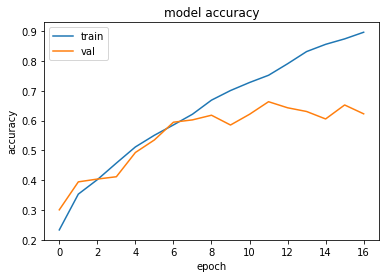

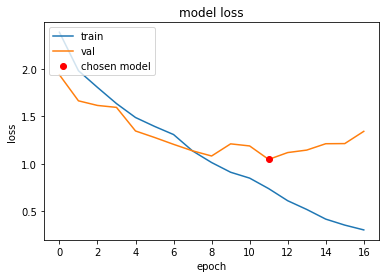

In [ ]:
CNN_Deeper_Dense.plot_results()

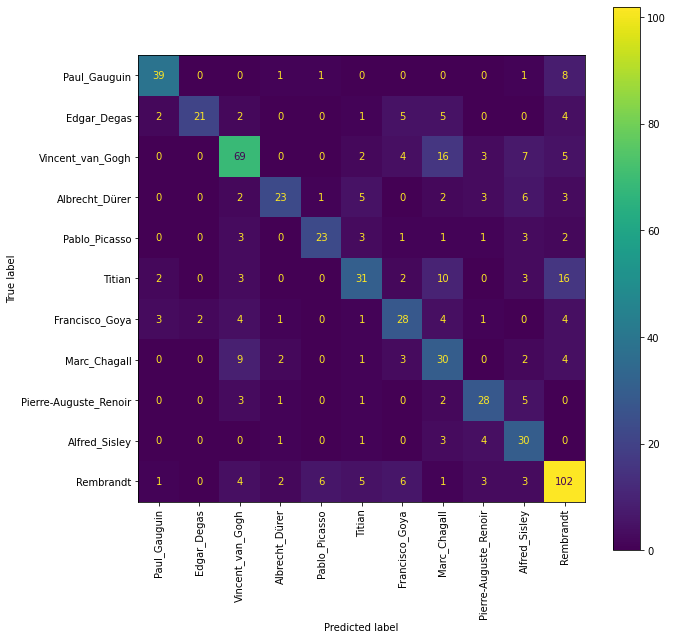

In [ ]:
CNN_Deeper_Dense.confusion_matrix()

In [ ]:
CNN_Deeper_Dense.plot_model_structure("CNN_Deeper_Dense")

## CNN: ConvLayer=3, Dropout, Strides, 2x Dense

In [ ]:
class CNN_7(CNN): 
  def __init__(self, train, test, val, name="CNN_Double_Dense"):
      super().__init__(train, test, val, name)

      inputs = keras.Input(shape=(224, 224, 3))
      x = layers.Rescaling(1. / 255)(inputs)
      x = layers.Conv2D(filters=32, kernel_size=3, strides=(7,7), padding="same")(x)
      x = layers.MaxPooling2D(pool_size=(4,4), strides=4)(x)
      x = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
      x = layers.MaxPooling2D(pool_size=(2,2))(x)
      x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
      #x = layers.MaxPooling2D(pool_size=(2,2))(x)
      x = layers.Flatten()(x)
      x = layers.Dense(100)(x)
      x = layers.Dropout(0.5)(x)
      x = layers.Dense(44)(x)
      x = layers.Dropout(0.5)(x)
      outputs = layers.Dense(len(CLASSES), activation="softmax")(x)
      self.model = keras.Model(inputs=inputs, outputs=outputs, name=self.name)

In [ ]:
CNN_Double_Dense = CNN_7(training_images, test_images, val_images)

In [ ]:
CNN_Double_Dense.summary()

Model: "CNN_Double_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_15 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                             

In [ ]:
CNN_Double_Dense.compile(learning_rate=0.001)

In [ ]:
CNN_Double_Dense.fit(epochs=40, patience=5, class_weights = CLASS_WEIGHTS)

Epoch 1/40
91/94 [============================>.] - ETA: 0s - loss: 2.5128 - accuracy: 0.2191
Epoch 1: val_loss improved from inf to 1.95723, saving model to /content/model/CNN_Double_Dense.h5
94/94 [==============================] - 9s 86ms/step - loss: 2.5083 - accuracy: 0.2177 - val_loss: 1.9572 - val_accuracy: 0.3146
Epoch 2/40
90/94 [===========================>..] - ETA: 0s - loss: 2.1445 - accuracy: 0.3177
Epoch 2: val_loss improved from 1.95723 to 1.76989, saving model to /content/model/CNN_Double_Dense.h5
94/94 [==============================] - 6s 62ms/step - loss: 2.1431 - accuracy: 0.3182 - val_loss: 1.7699 - val_accuracy: 0.3662
Epoch 3/40
91/94 [============================>.] - ETA: 0s - loss: 1.9548 - accuracy: 0.3812
Epoch 3: val_loss improved from 1.76989 to 1.60976, saving model to /content/model/CNN_Double_Dense.h5
94/94 [==============================] - 6s 63ms/step - loss: 1.9452 - accuracy: 0.3838 - val_loss: 1.6098 - val_accuracy: 0.4319
Epoch 4/40
90/94 [=====

In [ ]:
CNN_Double_Dense.evaluate()

21/21 [==============================] - 1s 52ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.81      0.84      0.82        50
          Edgar_Degas       0.94      0.42      0.59        40
     Vincent_van_Gogh       0.85      0.42      0.57       106
       Albrecht_Dürer       0.69      0.49      0.57        45
        Pablo_Picasso       0.63      0.65      0.64        37
               Titian       0.55      0.49      0.52        67
       Francisco_Goya       0.54      0.54      0.54        48
         Marc_Chagall       0.35      0.75      0.48        51
Pierre-Auguste_Renoir       0.62      0.62      0.62        40
        Alfred_Sisley       0.60      0.64      0.62        39
            Rembrandt       0.59      0.74      0.66       133

             accuracy                           0.60       656
            macro avg       0.65      0.60      0.60       656
         weighted avg       0.66      0.60      0.60       656

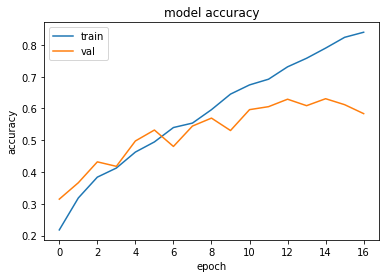

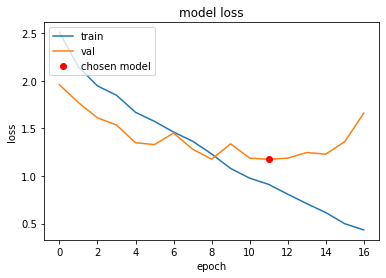

In [ ]:
CNN_Double_Dense.plot_results()

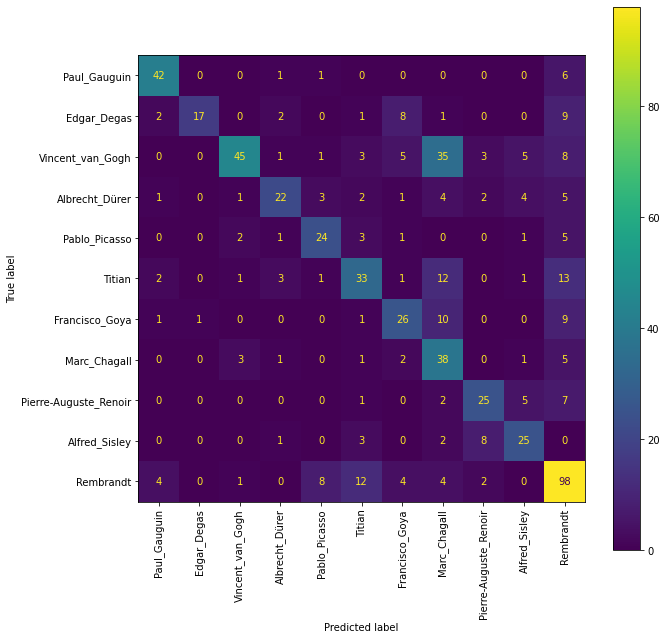

In [ ]:
CNN_Double_Dense.confusion_matrix()

In [ ]:
CNN_Double_Dense.plot_model_structure("2Dense")

## CNN: Single Inception layer

In [ ]:
def inception_layer(prec_layer, filters):
    branch_1 = layers.Conv2D(filters, (1,1), padding='same', activation='relu')(prec_layer)
    branch_1 = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(branch_1)

    branch_2 = layers.Conv2D(filters, (1,1), padding='same', activation='relu')(prec_layer)
    branch_2 = layers.Conv2D(filters, (5,5), padding='same', activation='relu')(branch_2)

    branch_3 = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(prec_layer)
    branch_3 = layers.Conv2D(filters, (1,1), padding='same', activation='relu')(branch_3)

    x = layers.concatenate([branch_1, branch_2, branch_3], axis = 3)
    return x


class CNN_Single_inception(CNN): 
    
  def __init__(self, train, test, val, name="CNN_inception_single"):
      super().__init__(train, test, val, name)

      inputs = keras.Input(shape=(224, 224, 3))
      x = layers.Rescaling(1. / 255)(inputs)
      x = layers.Conv2D(filters=32, kernel_size=3, strides=(7,7), padding="same")(x)
      x = layers.MaxPooling2D(pool_size=(4,4), strides=4)(x)
      
      x = inception_layer(x, 64)

      x = layers.MaxPooling2D(pool_size=(2,2))(x)

      x = layers.Flatten()(x)
      x = layers.Dense(190)(x)
      x = layers.Dropout(0.5)(x)
      outputs = layers.Dense(len(CLASSES), activation="softmax")(x)
      self.model = keras.Model(inputs=inputs, outputs=outputs, name=self.name)
  

In [ ]:
CNN_single_inc = CNN_Single_inception(training_images, test_images, val_images)

In [ ]:
CNN_single_inc.summary()

Model: "CNN_inception_single"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_15 (Rescaling)       (None, 224, 224, 3)  0           ['input_16[0][0]']               
                                                                                                  
 conv2d_48 (Conv2D)             (None, 32, 32, 32)   896         ['rescaling_15[0][0]']           
                                                                                                  
 max_pooling2d_30 (MaxPooling2D  (None, 8, 8, 32)    0           ['conv2d_48[0]

In [ ]:
CNN_single_inc.compile(learning_rate=0.001)

In [ ]:
CNN_single_inc.fit(epochs=40, patience=5, class_weights = CLASS_WEIGHTS)

Epoch 1/40
94/94 [==============================] - ETA: 0s - loss: 2.2282 - accuracy: 0.2899
Epoch 1: val_loss improved from inf to 1.61171, saving model to /content/model/CNN_inception_single.h5
94/94 [==============================] - 7s 66ms/step - loss: 2.2282 - accuracy: 0.2899 - val_loss: 1.6117 - val_accuracy: 0.4288
Epoch 2/40
91/94 [============================>.] - ETA: 0s - loss: 1.7039 - accuracy: 0.4385
Epoch 2: val_loss improved from 1.61171 to 1.60163, saving model to /content/model/CNN_inception_single.h5
94/94 [==============================] - 7s 75ms/step - loss: 1.7059 - accuracy: 0.4377 - val_loss: 1.6016 - val_accuracy: 0.3912
Epoch 3/40
91/94 [============================>.] - ETA: 0s - loss: 1.5046 - accuracy: 0.5041
Epoch 3: val_loss improved from 1.60163 to 1.33045, saving model to /content/model/CNN_inception_single.h5
94/94 [==============================] - 6s 64ms/step - loss: 1.5032 - accuracy: 0.5040 - val_loss: 1.3305 - val_accuracy: 0.4930
Epoch 4/40


In [ ]:
CNN_single_inc.evaluate()

21/21 [==============================] - 1s 50ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.95      0.74      0.83        50
          Edgar_Degas       1.00      0.23      0.37        40
     Vincent_van_Gogh       0.69      0.62      0.65       106
       Albrecht_Dürer       0.71      0.44      0.55        45
        Pablo_Picasso       0.64      0.62      0.63        37
               Titian       0.53      0.63      0.57        67
       Francisco_Goya       0.40      0.92      0.55        48
         Marc_Chagall       0.51      0.69      0.59        51
Pierre-Auguste_Renoir       0.65      0.78      0.70        40
        Alfred_Sisley       0.81      0.54      0.65        39
            Rembrandt       0.71      0.62      0.66       133

             accuracy                           0.62       656
            macro avg       0.69      0.62      0.61       656
         weighted avg       0.68      0.62      0.62       656

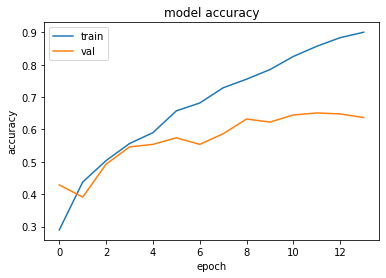

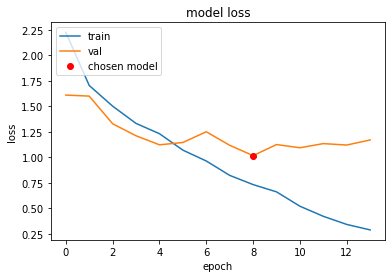

In [ ]:
CNN_single_inc.plot_results()

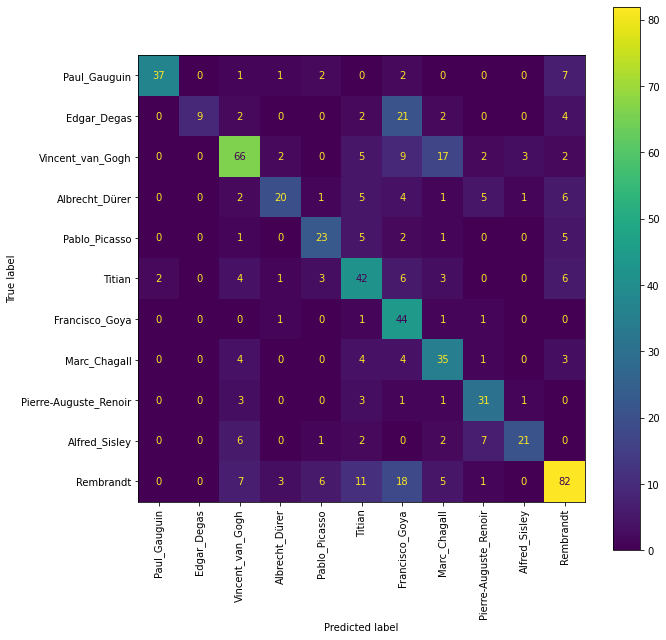

In [ ]:
CNN_single_inc.confusion_matrix()

In [ ]:
CNN_single_inc.plot_model_structure("CNN_Single_inception_struct")

## CNN: Double Inception layer

In [ ]:
def inception_layer(prec_layer, filters):
    branch_1 = layers.Conv2D(filters, (1,1), padding='same', activation='relu')(prec_layer)
    branch_1 = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(branch_1)

    branch_2 = layers.Conv2D(filters, (1,1), padding='same', activation='relu')(prec_layer)
    branch_2 = layers.Conv2D(filters, (5,5), padding='same', activation='relu')(branch_2)

    branch_3 = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(prec_layer)
    branch_3 = layers.Conv2D(filters, (1,1), padding='same', activation='relu')(branch_3)

    x = layers.concatenate([branch_1, branch_2, branch_3], axis = 3)
    return x


class CNN_Double_inception(CNN): 
    
  def __init__(self, train, test, val, name="CNN_Double_inception"):
      super().__init__(train, test, val, name)

      inputs = keras.Input(shape=(224, 224, 3))
      x = layers.Rescaling(1. / 255)(inputs)
      x = layers.Conv2D(filters=32, kernel_size=3, strides=(7,7), padding="same")(x)
      x = layers.MaxPooling2D(pool_size=(4,4), strides=4)(x)
      
      x = inception_layer(x, 64)

      x = layers.MaxPooling2D(pool_size=(2,2))(x)

      x = inception_layer(x, 128)

      x = layers.Conv2D(filters=128, kernel_size=3, padding="same")(x)
      x = layers.MaxPooling2D(pool_size=(2,2))(x)

      x = layers.Flatten()(x)
      x = layers.Dense(190)(x)
      x = layers.Dropout(0.5)(x)
      outputs = layers.Dense(len(CLASSES), activation="softmax")(x)
      self.model = keras.Model(inputs=inputs, outputs=outputs, name=self.name)
  

In [ ]:
CNN_Double_inc = CNN_Double_inception(training_images, test_images, val_images)

In [ ]:
CNN_Double_inc.summary()

Model: "CNN_Double_inception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_17 (Rescaling)       (None, 224, 224, 3)  0           ['input_18[0][0]']               
                                                                                                  
 conv2d_39 (Conv2D)             (None, 32, 32, 32)   896         ['rescaling_17[0][0]']           
                                                                                                  
 max_pooling2d_36 (MaxPooling2D  (None, 8, 8, 32)    0           ['conv2d_39[0]

In [ ]:
CNN_Double_inc.compile(learning_rate=0.001)

In [ ]:
CNN_Double_inc.fit(epochs=40, patience=5, class_weights = CLASS_WEIGHTS)

Epoch 1/40
94/94 [==============================] - ETA: 0s - loss: 2.3208 - accuracy: 0.2447
Epoch 1: val_loss improved from inf to 1.76601, saving model to /content/model/CNN_inception.h5
94/94 [==============================] - 9s 76ms/step - loss: 2.3208 - accuracy: 0.2447 - val_loss: 1.7660 - val_accuracy: 0.3302
Epoch 2/40
92/94 [============================>.] - ETA: 0s - loss: 1.8787 - accuracy: 0.3635
Epoch 2: val_loss improved from 1.76601 to 1.50239, saving model to /content/model/CNN_inception.h5
94/94 [==============================] - 7s 67ms/step - loss: 1.8715 - accuracy: 0.3662 - val_loss: 1.5024 - val_accuracy: 0.4476
Epoch 3/40
92/94 [============================>.] - ETA: 0s - loss: 1.6565 - accuracy: 0.4416
Epoch 3: val_loss improved from 1.50239 to 1.37072, saving model to /content/model/CNN_inception.h5
94/94 [==============================] - 7s 67ms/step - loss: 1.6588 - accuracy: 0.4414 - val_loss: 1.3707 - val_accuracy: 0.5055
Epoch 4/40
94/94 [==============

In [ ]:
CNN_Double_inc.evaluate()

21/21 [==============================] - 1s 49ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.81      0.88      0.85        50
          Edgar_Degas       0.80      0.70      0.75        40
     Vincent_van_Gogh       0.73      0.62      0.67       106
       Albrecht_Dürer       0.63      0.53      0.58        45
        Pablo_Picasso       0.67      0.76      0.71        37
               Titian       0.67      0.43      0.53        67
       Francisco_Goya       0.48      0.77      0.59        48
         Marc_Chagall       0.52      0.71      0.60        51
Pierre-Auguste_Renoir       0.59      0.80      0.68        40
        Alfred_Sisley       0.78      0.64      0.70        39
            Rembrandt       0.69      0.63      0.66       133

             accuracy                           0.66       656
            macro avg       0.67      0.68      0.67       656
         weighted avg       0.68      0.66      0.66       656

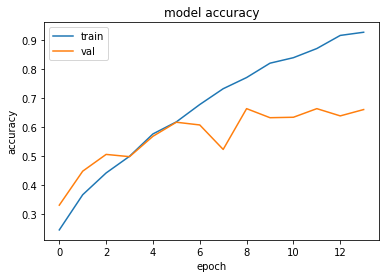

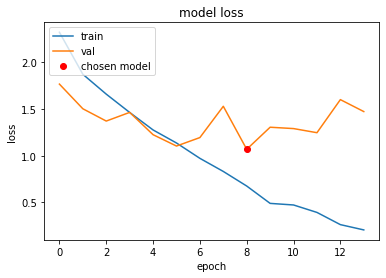

In [ ]:
CNN_Double_inc.plot_results()

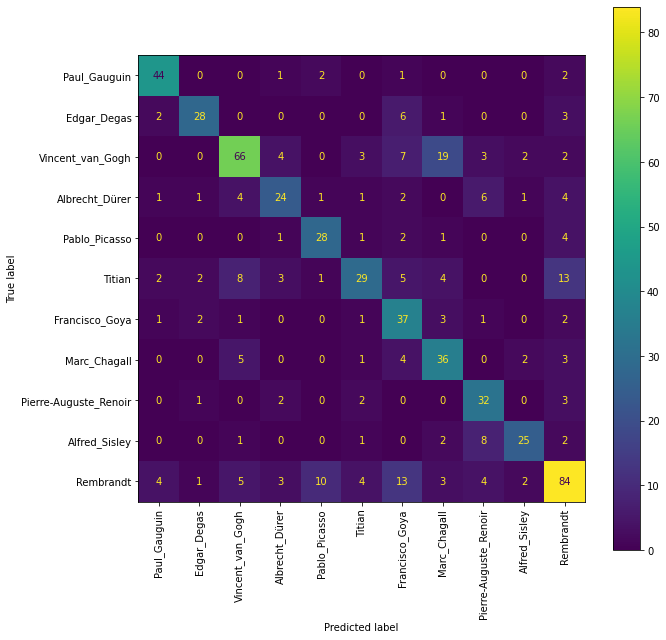

In [ ]:
CNN_Double_inc.confusion_matrix()

In [ ]:
CNN_Double_inc.plot_model_structure("CNN_Double_inception_struct")